In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask

from ekarus.e2e.single_stage_ao_class import SingleStageAO


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
ssao = SingleStageAO('calib_amplitude')
KL,_ = ssao.define_KL_modes(ssao.dm,zern_modes=2)

Initializing devices ...


In [ ]:
lambdaInM = ssao.pyr.lambdaInM
amp = 0.02
rMod = 3.0

ssao.pyr.set_modulation_angle(modulationAngleInLambdaOverD=rMod)
Rec,IM = ssao.compute_reconstructor(ssao.sc, KL, lambdaInM=lambdaInM, amps=amp)

Modulating 3 [lambda/D] with 20 modulation steps


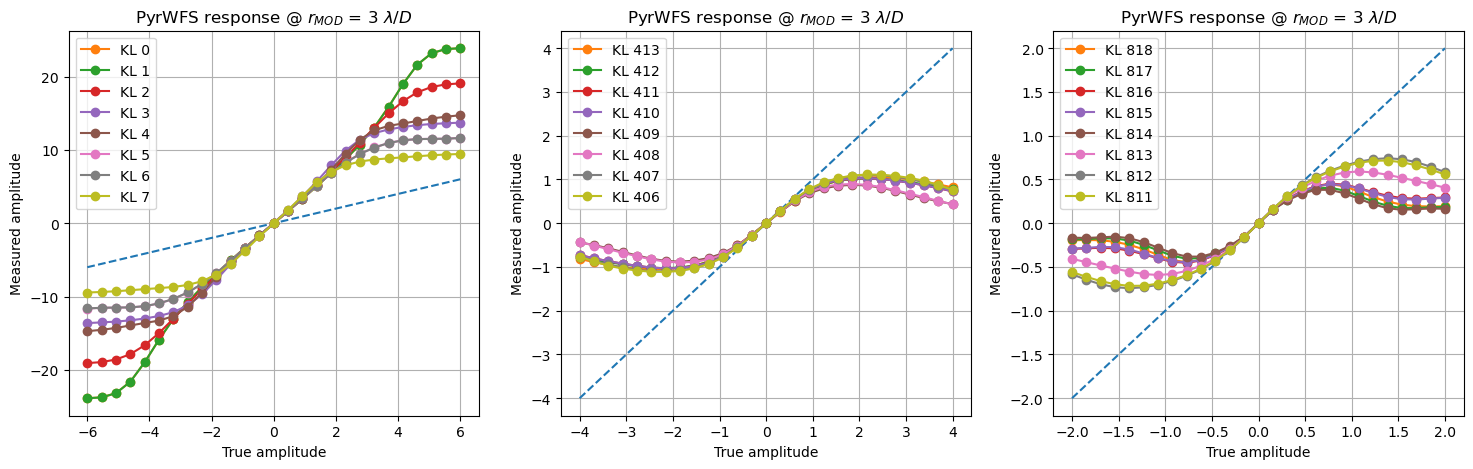

In [4]:
# Linearity check
Nmodes = 8
nRecModes = xp.shape(Rec)[0]

amp_vec = xp.linspace(-6,6,27,endpoint=True)
mid_amp_vec = xp.linspace(-4,4,27,endpoint=True)
low_amp_vec = xp.linspace(-2,2,27,endpoint=True)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')
plt.subplot(1,3,2)
plt.plot(xp.asnumpy(mid_amp_vec),xp.asnumpy(mid_amp_vec),'--')
plt.subplot(1,3,3)
plt.plot(xp.asnumpy(low_amp_vec),xp.asnumpy(low_amp_vec),'--')

lambdaOverD = lambdaInM/ssao.pupilSizeInM
field_amp = 1-ssao.cmask


for j in range(Nmodes):

    zid = j
    meas_amp = xp.zeros_like(amp_vec)

    mid_zid = nRecModes//2 + Nmodes//2 - j
    mid_meas_amp = xp.zeros_like(amp_vec)

    rev_zid = nRecModes - j - 1
    rev_meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        input_field = field_amp*xp.exp(1j*reshape_on_mask(KL[zid],ssao.cmask)*amp_vec[k], dtype=ssao.cdtype)
        slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
        modes = Rec @ slopes
        meas_amp[k] = modes[zid]

        input_field = field_amp*xp.exp(1j*reshape_on_mask(KL[mid_zid],ssao.cmask)*mid_amp_vec[k], dtype=ssao.cdtype)
        slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
        modes = Rec @ slopes
        mid_meas_amp[k] = modes[mid_zid]

        input_field = field_amp*xp.exp(1j*reshape_on_mask(KL[rev_zid],ssao.cmask)*low_amp_vec[k], dtype=ssao.cdtype)
        slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, nPhotons=None)
        modes = Rec @ slopes
        rev_meas_amp[k] = modes[rev_zid]
    
    plt.subplot(1,3,1)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(meas_amp),'-o', label=f'KL {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 3 $\lambda/D$')
    plt.grid(True)

    plt.subplot(1,3,2)
    plt.plot(xp.asnumpy(mid_amp_vec), xp.asnumpy(mid_meas_amp),'-o', label=f'KL {mid_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 3 $\lambda/D$')
    plt.grid(True)
    
    plt.subplot(1,3,3)
    plt.plot(xp.asnumpy(low_amp_vec), xp.asnumpy(rev_meas_amp),'-o', label=f'KL {rev_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 3 $\lambda/D$')
    plt.grid(True)